In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances_argmin_min
import seaborn as sb
from yellowbrick.cluster import KElbowVisualizer
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import plotly.figure_factory as ff
from plotly.figure_factory import create_dendrogram
from sklearn.preprocessing import MinMaxScaler

In [305]:
# Se cargan los datos. 
CollegeScoreCard=pd.read_csv('CollegeScorecard.csv', sep=',', encoding = 'utf-8')
# Cantidad de datos y número de variables
CollegeScoreCard.shape

C:\Users\Andres\AppData\Local\Temp/ipykernel_1296/1466162896.py:2: DtypeWarning:

Columns (7,9,1427,1542,1561,1575) have mixed types. Specify dtype option on import or set low_memory=False.



(7804, 1725)

In [306]:
# data[data['INSTNM'].str.contains('niversity') & data["COSTT4_P"].notnull()]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu')]
# data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') | data['INSTNM'].str.contains('chool') | data['INSTNM'].str.contains('enter')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter') & ~data['INSTNM'].str.contains('cadem')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter') & ~data['INSTNM'].str.contains('cadem')  & ~data['INSTNM'].str.contains('CET')]
# data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') ]

In [307]:
def trans_variable_control(p):
    p_mod=''
    if p == 1:
        return "PUBLIC"
    elif p == 2:
        return "PRIVATE NONPROFIT"
    else:
        return "PRIVATE FOR-PROFIT"

In [308]:
# Depuracion y eleccion de variables
data=CollegeScoreCard[CollegeScoreCard["CURROPER"]!=0]
data=data[data["DISTANCEONLY"]!=1]
data=data[["INSTNM","CONTROL","COSTT4_A","COSTT4_P","PCTPELL","UG25abv","PCIP11","PCIP14","PCIP16","PCIP26","PCIP27","PCIP42","PCIP52"]]
data=data[data["COSTT4_A"].notnull() | data["COSTT4_P"].notnull()]
data=data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') ]
data=data[data["COSTT4_A"].notnull()]
data=data[data['UG25abv'].notnull()]
data=data.drop(['COSTT4_P'],axis=1)
data["CONTROL"]=data["CONTROL"].apply(trans_variable_control)
data=data.drop([2124])

In [309]:
data=data.rename(columns={'CONTROL': 'Tipo_de_Entidad','COSTT4_A': 'Costo_Anual_Estudio','PCTPELL': 'Becados_Pell','UG25abv': 'Estudiantes_Mayor_25','PCIP11': 'Computer_Science', 'PCIP14': 'Engineering','PCIP16': 'Linguistics', 'PCIP26': 'Biological_Science','PCIP27': 'Mathematics','PCIP42': 'Psychology','PCIP52': 'Business'})

In [310]:
data['Tipo_de_Entidad'].value_counts()

PUBLIC                1584
PRIVATE NONPROFIT     1259
PRIVATE FOR-PROFIT     904
Name: Tipo_de_Entidad, dtype: int64

In [311]:
#Dymmys
data= pd.get_dummies(data, columns=['Tipo_de_Entidad'])

In [312]:
data.head()

,INSTNM,Costo_Anual_Estudio,Becados_Pell,Estudiantes_Mayor_25,Computer_Science,Engineering,Linguistics,Biological_Science,Mathematics,Psychology,Business,Tipo_de_Entidad_PRIVATE FOR-PROFIT,Tipo_de_Entidad_PRIVATE NONPROFIT,Tipo_de_Entidad_PUBLIC
0,Alabama A & M University,18888.0,0.7115,0.1049,0.0348,0.1175,0.0000,0.1026,0.0199,0.0579,0.1457,0,0,1
1,University of Alabama at Birmingham,19990.0,0.3505,0.2422,0.0099,0.0632,0.0090,0.0619,0.0135,0.0840,0.1765,0,0,1
2,Amridge University,12300.0,0.6839,0.8540,0.0411,0.0000,0.0000,0.0000,0.0000,0.0000,0.0685,0,1,0
3,University of Alabama in Huntsville,20306.0,0.3281,0.2640,0.0273,0.2566,0.0173,0.0855,0.0218,0.0218,0.2247,0,0,1
4,Alabama State University,17400.0,0.8265,0.1270,0.0450,0.0000,0.0000,0.1033,0.0183,0.0617,0.1067,0,0,1


In [313]:
data.describe()

,Costo_Anual_Estudio,Becados_Pell,Estudiantes_Mayor_25,Computer_Science,Engineering,Linguistics,Biological_Science,Mathematics,Psychology,Business,Tipo_de_Entidad_PRIVATE FOR-PROFIT,Tipo_de_Entidad_PRIVATE NONPROFIT,Tipo_de_Entidad_PUBLIC
count,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000,3747.000000
mean,24340.439018,0.485286,0.361186,0.043060,0.012511,0.004729,0.024639,0.005057,0.031553,0.149910,0.241260,0.336002,0.422738
std,12373.111799,0.207783,0.236188,0.095056,0.052986,0.013116,0.044774,0.010082,0.061696,0.158297,0.427905,0.472403,0.494060
min,4157.000000,0.000000,0.000500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13794.500000,0.328050,0.169550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045050,0.000000,0.000000,0.000000
50%,22646.000000,0.453800,0.336200,0.015000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118600,0.000000,0.000000,0.000000
75%,30694.500000,0.639500,0.527800,0.038350,0.000000,0.003800,0.038050,0.006850,0.051950,0.195900,0.000000,1.000000,1.000000
max,74473.000000,1.000000,1.000000,1.000000,0.914300,0.375600,1.000000,0.125000,0.882400,1.000000,1.000000,1.000000,1.000000


In [314]:
university=data[data['INSTNM'].str.contains('niversity')]
college=data[data['INSTNM'].str.contains('ollege')]
institution=data[data['INSTNM'].str.contains('nstitu') ]

In [315]:
nombresUniversity=university['INSTNM']
university=university.drop(['INSTNM'],axis=1)
nombresCollege=college['INSTNM']
college=college.drop(['INSTNM'],axis=1)
nombresInstitution=institution['INSTNM']
institution=institution.drop(['INSTNM'],axis=1)

In [316]:
# copy the data
norm_university = university.copy()
  
# apply normalization techniques
column = 'Costo_Anual_Estudio'
norm_university[column] = MinMaxScaler().fit_transform(np.array(norm_university[column]).reshape(-1,1))

In [317]:
# copy the data
norm_college = college.copy()
  
# apply normalization techniques
column = 'Costo_Anual_Estudio'
norm_college[column] = MinMaxScaler().fit_transform(np.array(norm_college[column]).reshape(-1,1))

In [318]:
# copy the data
norm_institution = institution.copy()
  
# apply normalization techniques
column = 'Costo_Anual_Estudio'
norm_institution[column] = MinMaxScaler().fit_transform(np.array(norm_institution[column]).reshape(-1,1))

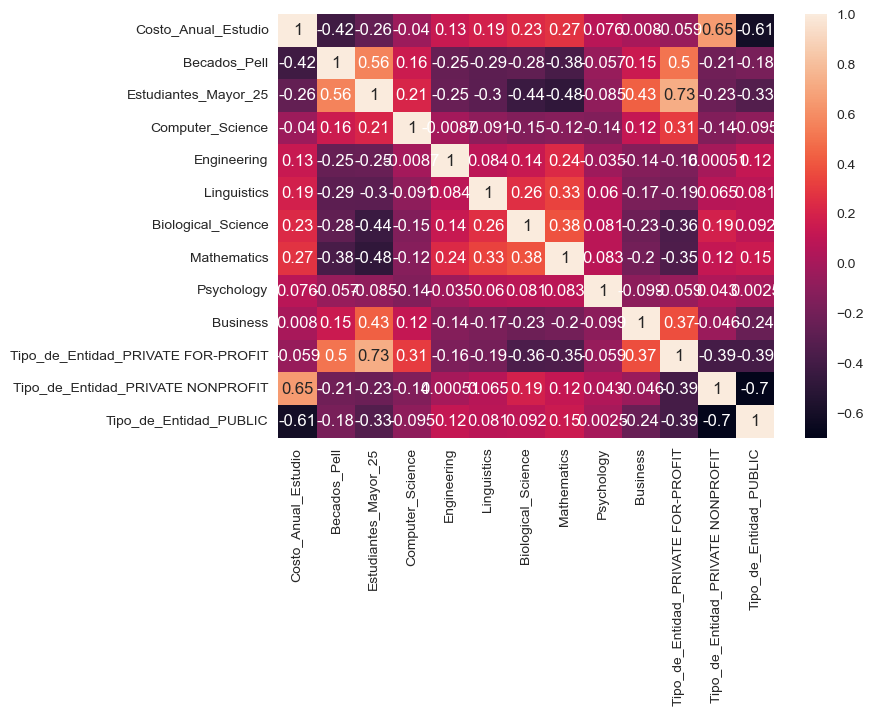

In [319]:
UnicorrMatrix = norm_university.corr()
sb.heatmap(UnicorrMatrix, annot=True)
plt.show()

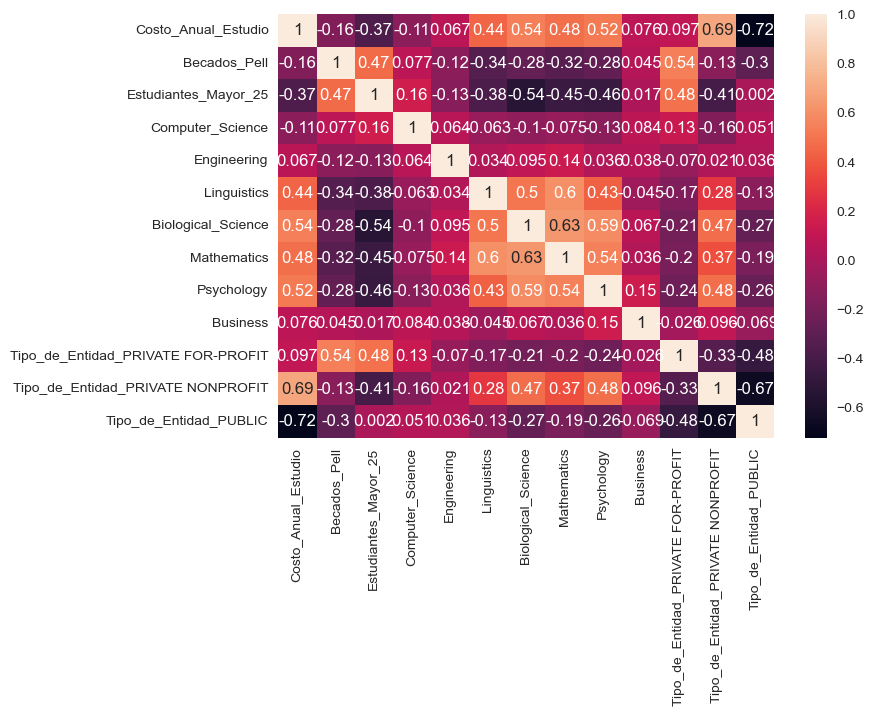

In [320]:
CollcorrMatrix = norm_college.corr()
sb.heatmap(CollcorrMatrix, annot=True)
plt.show()

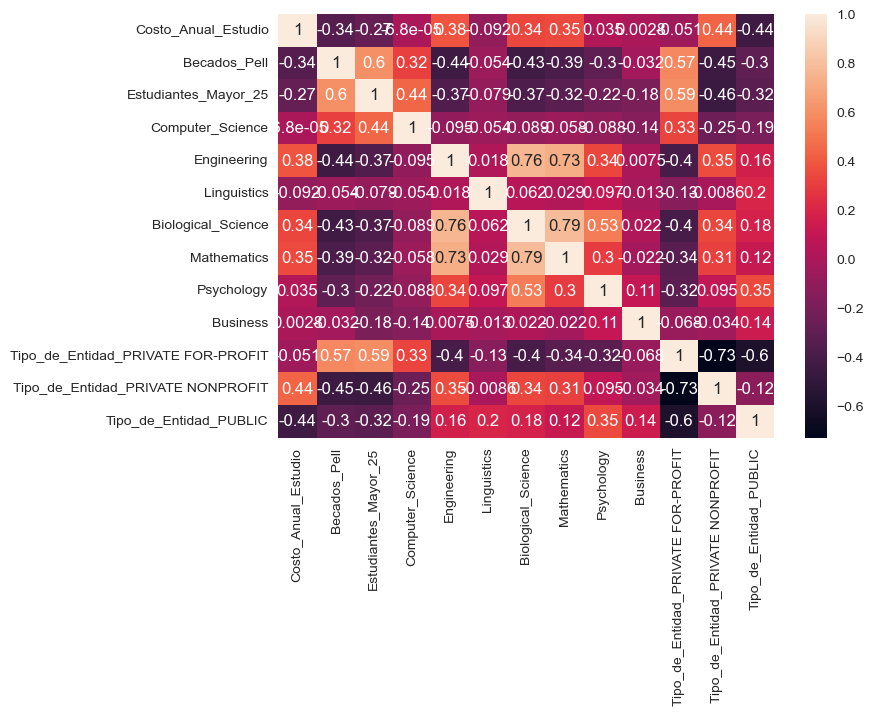

In [321]:
InstcorrMatrix = norm_institution.corr()
sb.heatmap(InstcorrMatrix, annot=True)
plt.show()

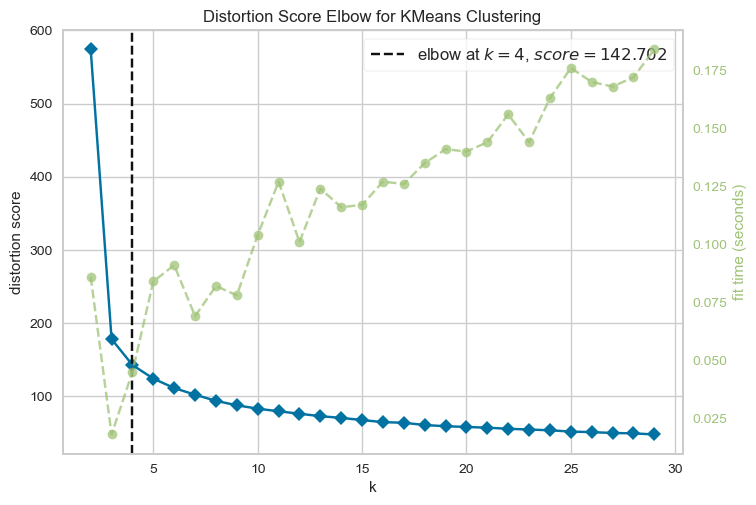

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [322]:
modelUni = KMeans()
visualizer = KElbowVisualizer(modelUni, k=(2,30), timings= True)
Unifit=norm_university.sample(int(len(norm_university)*1))
visualizer.fit(Unifit)        
visualizer.show() 

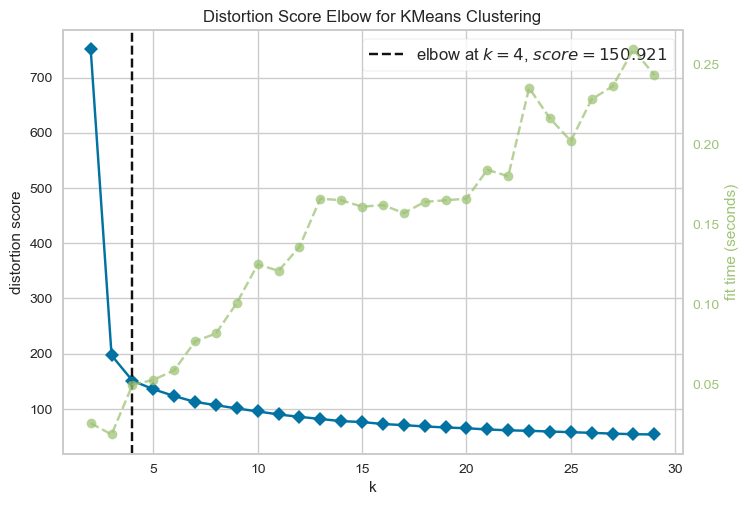

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [323]:
modelColl = KMeans()
visualizer = KElbowVisualizer(modelColl, k=(2,30), timings= True)
Collfit=norm_college.sample(int(len(norm_college)*1))
visualizer.fit(Collfit)        
visualizer.show() 

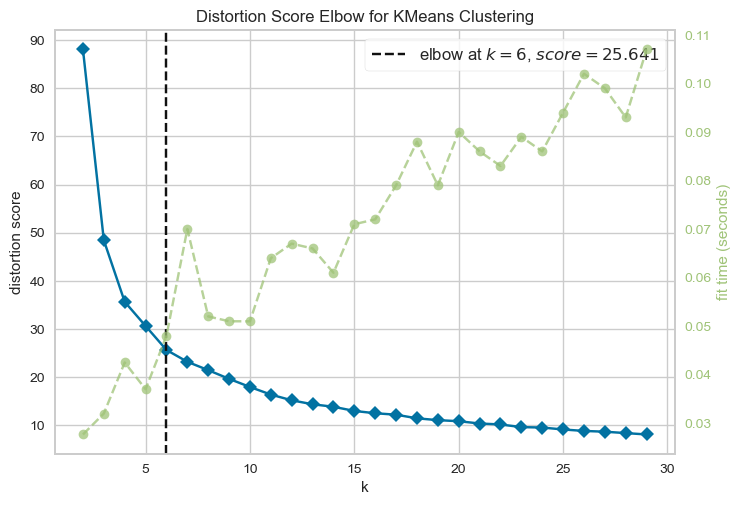

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [324]:
modelInst = KMeans()
visualizer = KElbowVisualizer(modelInst, k=(2,30), timings= True)
Instfit=norm_institution.sample(int(len(norm_institution)*1))
visualizer.fit(Instfit)        
visualizer.show() 

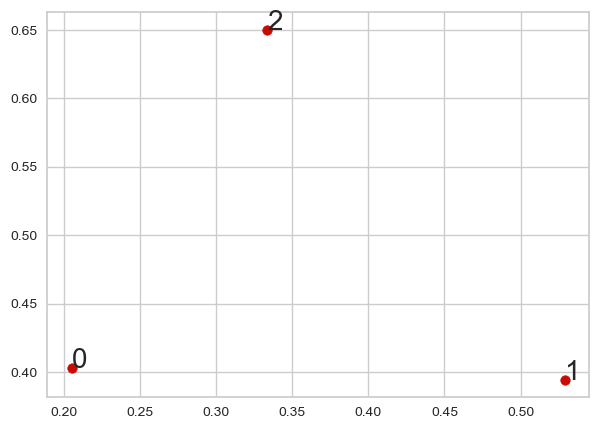

In [325]:
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(Unifit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [326]:
university['Nombre Universidad']=nombresUniversity
university['Clasificacion']=labels_2D
university['Clasificacion'].value_counts()

0    556
1    556
2    239
Name: Clasificacion, dtype: int64

In [327]:
grupo0=university[university['Clasificacion']==0]
grupo1=university[university['Clasificacion']==1]
grupo2=university[university['Clasificacion']==2]
# grupo3=university[university['Clasificacion']==3]

In [328]:
df=pd.DataFrame()
df['grupo0']=grupo0.median()
df['grupo1']=grupo1.median()
df['grupo2']=grupo2.median()
# df['grupo3']=grupo3.median()
df

C:\Users\Andres\AppData\Local\Temp/ipykernel_1296/3900488160.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Andres\AppData\Local\Temp/ipykernel_1296/3900488160.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Andres\AppData\Local\Temp/ipykernel_1296/3900488160.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,grupo0,grupo1,grupo2
Costo_Anual_Estudio,24238.50000,24139.00000,23763.0000
Becados_Pell,0.41735,0.40770,0.4242
Estudiantes_Mayor_25,0.24290,0.23070,0.2121
Computer_Science,0.01420,0.01445,0.0174
Engineering,0.00000,0.00000,0.0000
Linguistics,0.00080,0.00000,0.0000
Biological_Science,0.03130,0.03525,0.0311
Mathematics,0.00460,0.00470,0.0045
Psychology,0.04670,0.04515,0.0449
Business,0.17550,0.18015,0.1786


In [329]:
# dict for the dataframes and their names
dfs = {"grupo0" : grupo0, "grupo1": grupo1, "grupo2" : grupo2}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Box(y = dfs[i]["Estudiantes_Mayor_25"], 
                                   name = i))
fig.show()

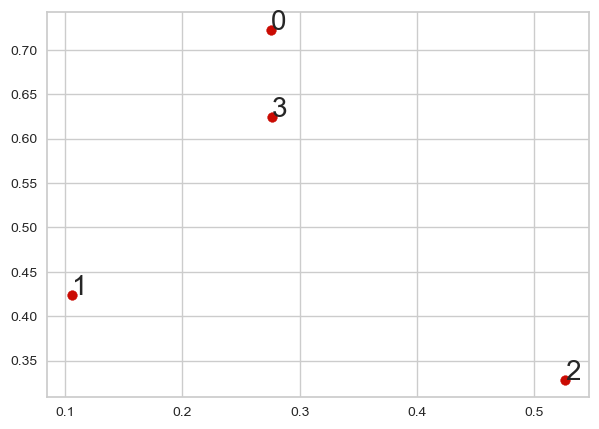

In [296]:
kmeans_model_2D = KMeans(n_clusters=4, max_iter=1000).fit(Collfit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [297]:
college['Nombre Collage']=nombresCollege
college['Clasificacion']=labels_2D
college['Clasificacion'].value_counts()

1    1023
0     403
2     391
3     275
Name: Clasificacion, dtype: int64

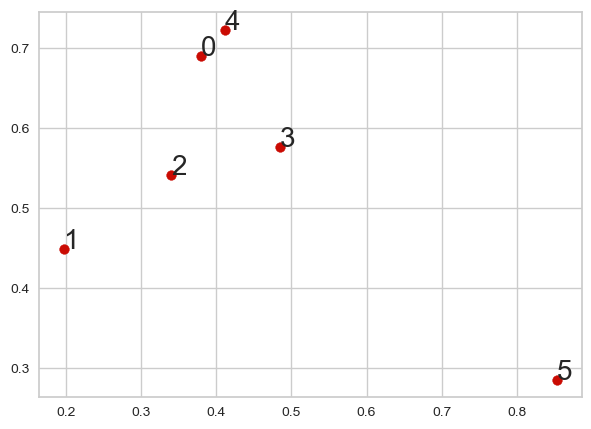

In [298]:
kmeans_model_2D = KMeans(n_clusters=6, max_iter=1000).fit(Instfit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [299]:
institution['Nombre Collage']=nombresInstitution
institution['Clasificacion']=labels_2D
institution['Clasificacion'].value_counts()

4    125
0     90
3     66
1     31
5     23
2     21
Name: Clasificacion, dtype: int64

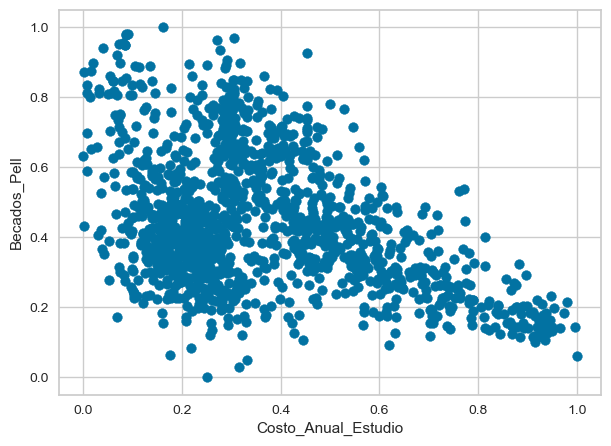

In [300]:
fig = plt.subplots(figsize=(7, 5))

plt.scatter(norm_university['Costo_Anual_Estudio'], norm_university['Becados_Pell'])

plt.xlabel('Costo_Anual_Estudio')
plt.ylabel('Becados_Pell')

plt.show()

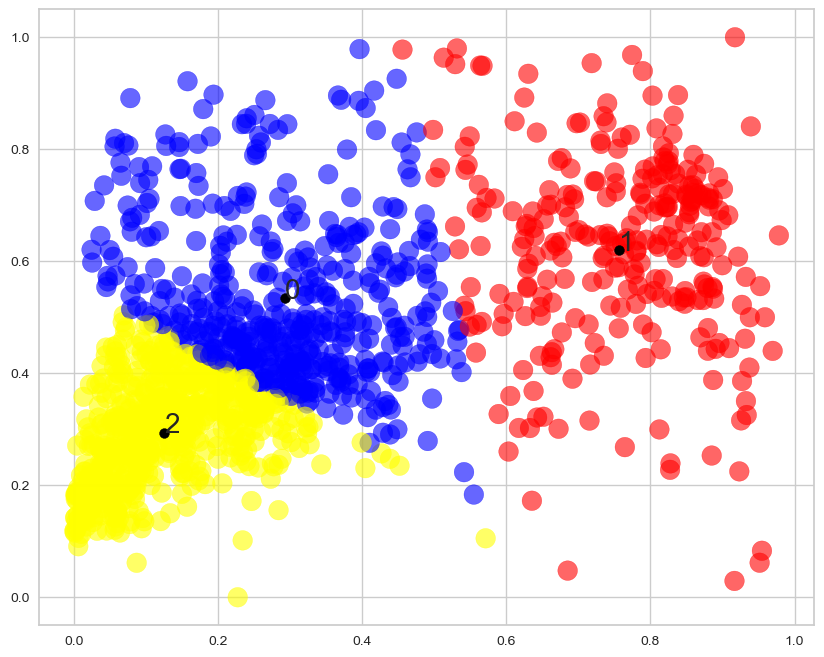

In [303]:
df_2D = norm_university[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red','yellow']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [ ]:
df_2D = norm_college[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [ ]:
df_2D = norm_institution[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)